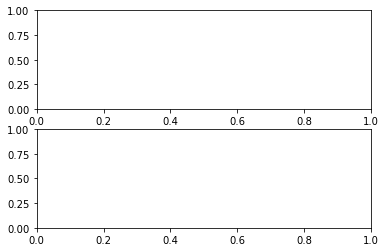

In [1]:
# here we import the light curve data as well as import some functions and other misc.
import numpy as np
import numpy as numpy
from scipy.signal import lombscargle
import matplotlib.pyplot as plt
import scipy.signal as signal
from astropy.timeseries import LombScargle
import scipy
from scipy.signal import find_peaks
from numpy import sin
from scipy import optimize
from multiprocessing import Pool
import statistics
import sys
import math
from scipy import interpolate

pi = 3.14159265358979323846

plt.ion()
fig, (ax1, ax2) = plt.subplots(2)



xu1, yu1 = np.loadtxt("KIC_6791060_all_jump_removed.dat", unpack = True, usecols = [0,2])


frequency, power = LombScargle(xu1, yu1).autopower()

periods = 1/frequency

#        here we graph the data and the LombScarge (this will probbably be deleted later)
#plt.plot(periods, power)
#plt.plot(xu1, yu1)
#plt.show()

# nyquist_frequency is frequency/2
#######################################################################################




In [2]:

#######################################################################################
#  here we calculate the sampling frequency and nyquist frequency and period
sampling_frequency =  len(xu1)/(xu1[len(xu1)-1]-xu1[0])
nyquist_frequency = sampling_frequency/2
nyquist_period = 1/nyquist_frequency

#print ("nyquist_period:", nyquist_period)
#print ("nyquist_frequency:", nyquist_frequency)
#######################################################################################



#######################################################################################
#program for finding peaks and making sure they are large enough to be significant
all_peaks = []
periods_counter = 0
for periods_values in range(len(periods)-1):
	periods_counter += 1
	if ((((power[periods_counter] - power[periods_counter - 1]) > 0.2*power[periods_counter-1] ) \
	or ((power[periods_counter] - power[periods_counter - 1]) > 0.2*power[periods_counter-1] )) \
	and ((power[periods_counter] > power[periods_counter - 1]) \
	and (power[periods_counter] > power[periods_counter + 1])) \
	and (power[periods_counter] > 0.01)):
		all_peaks.append(periods[periods_counter])
#######################################################################################



In [3]:


#######################################################################################
#program to ensure peaks are far enough apart to be distinct periods
peaks_counter = 0
distinct_peaks = []
for peaks in range(len(all_peaks)-2):
	peaks_counter += 1
	if  (all_peaks[peaks_counter] - all_peaks[peaks_counter+1]) > int(0.005):
		distinct_peaks.append(all_peaks[peaks_counter])

peaks_counter2 = 0
distinct_peaks2 = []
for peaks in range(len(distinct_peaks)-2):
	peaks_counter2 += 1
	if  (distinct_peaks[peaks_counter2] - distinct_peaks[peaks_counter2+1]) > int(0.005):
		distinct_peaks2.append(distinct_peaks[peaks_counter2])
#######################################################################################



#######################################################################################
# defining printing functions to check answers for error (printlist) 
def printlist(lst):
	for a in range(len(lst)-1):
		print (lst[a])
		
def printlist2(lst , lst2):
	for a in range(len(lst)-1):
		print (lst[a], lst2[a])

def printlistnumbered(lst):
	n = 1
	for a in range(len(lst)-1):
		print (n, ")" ," " , lst[a], sep = '')
		n +=1
		
#print ("all peak:")
#print (printlist(all_peaks))
#print (" ")
#print ("distinct peaks:")
#print (printlist(distinct_peaks2))
#######################################################################################



#######################################################################################
#function that takes the average value of a list ######################################
def average(lst):
	total = 0
	for i in lst:
		total += i
	average = total/ len(lst)
	return average
#######################################################################################



#######################################################################################
#program that stores that parameters of the function in a dynamic parameters dictionary
parameters_guess = {}           #used to store the parameters of the sine function


parameter_index = 0

for peak in distinct_peaks2:
	if (peak > nyquist_period):
		parameter_index = parameter_index + 1
		#using form An*sin(2*pi*an*x+bn)
		parameters_guess['A' + str(parameter_index)]='1'
		parameters_guess['a' + str(parameter_index)]= peak
		parameters_guess['b' + str(parameter_index)]='1'


print ("parameters guess: ", parameters_guess)
#######################################################################################



#######################################################################################
# function to calculate the standard deviation of a list of deviations
def standard_deviation(lst):
	total = 0
	for p in lst:
		total += p**2
	if len(lst) > 0:
		sd = (total / len(lst))**(0.5)
		#print ("total:", total)
		#print ("n=",  len(lst))
		
		return sd
#######################################################################################




parameters guess:  {'A1': '1', 'a1': 0.3433814071877263, 'b1': '1', 'A2': '1', 'a2': 0.1717448463541971, 'b2': '1'}


In [4]:

#######################################################################################
#fits sin equations to the data in sets of *length* data points and deviation and sd###
length = 40     #can be adjusted for different fittings
x_value = 2650
initial = x_value
running_sd = []

for x_values in range(len(xu1)-64800):
	ax2.clear()
	ax1.clear()
	def test_func(x, A, b, A2, b2, Z):
		
		#y = parameters['A1']*sin(2*pi*parameters['a1']*x+paramters['b1']) + paramters['A2']*sin(2*pi*paramters['a2']*x+paramters['b2']) + Z
		return A*sin(2*pi*(1/parameters_guess['a1'])*x+b) + A2*sin(2*pi*(1/parameters_guess['a2'])*x+b2) + Z
		
	params, params_covariance = optimize.curve_fit(test_func, xu1[x_value:x_value+length], yu1[x_value:x_value+length],
		                                                       p0=[2, 2, 2, 2, 2], maxfev = 100000)
	ax1.scatter(xu1, yu1, label='Data', color = 'green')                                   
	ax1.plot(xu1[x_value: x_value+length], test_func(xu1[x_value:x_value+length], params[0], params[1], params[2], params[3], params[4]), label='Fitted function', color = "blue")
	deviation = []
	for point in range(x_value, x_value+length):
		deviation.append( yu1[point] - ( params[0]*sin(2*pi*(1/parameters_guess['a1'])*point+params[1]) + params[2]*sin(2*pi*(1/parameters_guess['a2'])*point+params[3]) + params[4] ) )
	running_sd.append( standard_deviation(deviation) )
	x_value+=(1)
	ax1.set_xlim([xu1[x_value]-0.5, xu1[x_value+length]+0.5])
	#print (x_value-2743, len(running_sd))
	ax2.scatter(xu1[0:(x_value - initial)] , running_sd, 2, color = 'black', linewidth = 2)
	ax2.axhline(y=statistics.median(running_sd))
	running_sd_deviation = []
	for i in running_sd:
		running_sd_deviation.append(abs(i-average(running_sd)))
	ax2.axhline(y=statistics.median(running_sd) + 2.5* standard_deviation(running_sd_deviation), color = 'red')
	ax2.axhline(y=statistics.median(running_sd) - 2.5* standard_deviation(running_sd_deviation), color = 'red')
	#print (3* standard_deviation(running_sd))
	fig.canvas.draw()
	fig.canvas.flush_events()
	
#######################################################################################



In [5]:


#######################################################################################
#running standard deviation dependant on *length* and flares###########################

flares_not_3 = []
flares_starttime = []
flares_starttime_index = []
flares_endtime = []
flares_endtime_index = []
flare_lengths = []
i=0
for k in range(len(running_sd)-length):
	if running_sd[i] > average(running_sd) + 2.5*standard_deviation(running_sd_deviation):
		flares_not_3.append(xu1[i]) 
		for p in range(20,0,-1):
			if running_sd[i+length+p-5] > average(running_sd) + 2.5*standard_deviation(running_sd_deviation):
				flares_starttime.append(xu1[i+initial])
				flares_starttime_index.append(i+initial)
				flares_endtime.append(xu1[i+p+initial])
				flares_endtime_index.append(i+p+initial)
				flare_lengths.append(p)
				i = i + length + p - 5
				break
	#print (i)
	i = i+1
	#if running_sd[i] > average(running_sd) - 3*standard_deviation(running_sd):
	#	flares_not_3.append(xu1[i])
print ('flares_not_3', flares_not_3)
print ('flares_starttime', flares_starttime)
print ('flares_starttime_index', flares_starttime_index)
print ('flares_endtime', flares_endtime)
print ('flares_endtime_index', flares_endtime_index)
print ('flare_lengths',flare_lengths)
#######################################################################################



#######################################################################################
# here we will remove the flares from the data
xu3 = xu1
yu3 = yu1
for n in range(len(flares_starttime)-1):
	for i in range(flares_starttime_index[n], flares_endtime_index[n]):
		del xu3[i]
		del yu3[i]

#######################################################################################



#######################################################################################
# here we will use the new flareless data and interpolate it
f1 = interpolate.interp1d(xu3, yu3)

xu3_new = np.arange(xu3[0], xu3[len(xu3)-2], 0.0001)

yu3_new = f1(xu3_new)   # use interpolation function returned by `interp1d`

#ax1.plot(xu3, yu3, 'o', xu3_new, y_u3new, '-')

#######################################################################################



#######################################################################################
# here we interpolate the original lightcurve data with the flares
f2 = interpolate.interp1d(xu1, yu1)

xu1_new = np.arange(xu1[0], xu1[len(xu1)-2], 0.0001)

yu1_new = f2(xu1_new)

#######################################################################################



#######################################################################################
# here we calculate the area between the flareless curve and the flarecurve

energy = []
for q in range(len(flares_starttime)):
	
	sector = flares_endtime[q] - flares_starttime[q]
	limit = 1
	area = 0
	for p in range(limit):
		print (f2(flares_starttime[q] + (p * sector) / limit))
		print (f1(flares_starttime[q]+ (p * sector) / limit))
		print (f2(flares_starttime[q]+ (p * sector) / limit) - f1(flares_starttime[q]+ (p * sector) / limit))
		dA = int((f2(flares_starttime[q]+ (p * sector) / limit) - f1(flares_starttime[q]+ (p * sector) / limit)) * (1/limit))
		area += dA
	energy.append(area)
print ("energy", energy)
#######################################################################################



#original_stdout = sys.stdout # Save a reference to the original standard output

#with open('filename.txt', 'w') as f:
#    sys.stdout = f # Change the standard output to the file we created.
#    print(printlist2(running_sd, xu1[2700:len(xu1)-62400]))
#    sys.stdout = original_stdout # Reset the standard output to its original value

#plt.savefig("flares.png")

#	flare

#print ("Running SD:")
#printlistnumbered(running_sd)

#ax2.scatter(xu1[0:945] , running_sd, 2)


flares_not_3 [122.3166]
flares_starttime [185.2545]
flares_starttime_index [2737]
flares_endtime [185.3158]
flares_endtime_index [2740]
flare_lengths [3]
0.999698
0.999698
0.0
energy [0]
